In [1]:
import pandas as pd

# Charts!

Charts are great! Charts are also really fiddly and annoying. Pandas provides to built-in charting functionality, but for more sophisticated stuff we'll move to using one of Pandas' "best friends", `matplotlib`. Let's import that now.

In [2]:
import matplotlib.pyplot as plt
% matplotlib inline

We're importing the `pyplot` "folder" of the `matplotlib` library, and we're giving it a shorthand name, `plt`. That thing with the percent sign is a "magic function" that tells Jupyter Notebook (the thing that's displaying and running this code) to display charts from `matplotlib` "in line", i.e. in this window, rather than opening a new window. This is pretty much boilerplate code for doing charting with Jupyter Notebook. 

## Basic Charts

The easiest way to make a chart is to rely on Pandas' built-in implementation of `matplotlib`. Every `Series` and `DataFrame` object has a `plot` method, which will pass the data it contains to `matplotlib`, and try make a chart out of it. Let's see what that looks like.

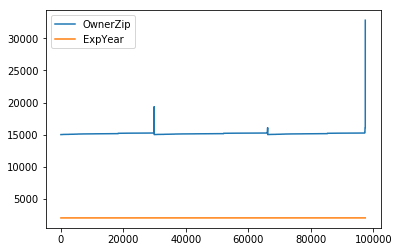

In [3]:
dogs = pd.read_csv('https://raw.githubusercontent.com/SimonCarryer/pandas_tutorial/master/data/dog_registrations.csv')
dogs.plot()

Not very useful! It's found a couple of numeric columns (`OwnerZip` and `ExpYear`) and tried to plot them on a line chart. Notice a couple of interesting things though:
* It automatically gives each series a different colour
* It uses the index of the `DataFrame` as its x-axis

Let's try plotting an individual `Series`.

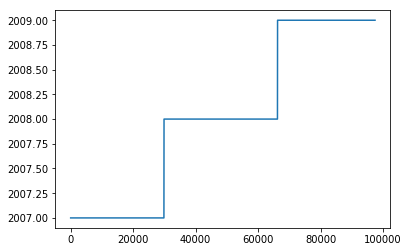

In [4]:
dogs['ExpYear'].plot()

Slightly better! But there's some problems:
* It's still using the index as the x-axis, which isn't very meaningful
* It's choosing its own scale for the y-axis, which means it's not starting at zero.

Let's try giving it some more appropriate data.

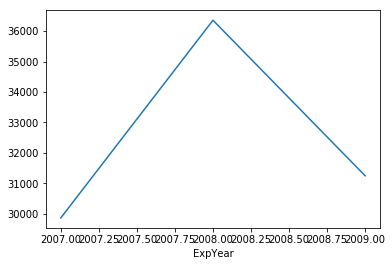

In [5]:
dogs.groupby('ExpYear')['Breed'].count().plot()

# remember that 'Breed' here is just picking a column to count, it's not using the data in the column at all.

This is a bit better - we've got some useful information here. Registrations were highest in 2008, and lower again in 2009. There's some problems though. The chart is still using the `Series` index as its x-axis, and although that more usefully contains years rather than row numbers, the chart doesn't really know how to treat them - the axis labels have interpolated values, and it's showing decimal points. Let's see if we can make it better. 

Firstly, instead of using the default `plot` method, we're going to use a more specific one - `plot.line`. As well as being a stand-alone method, `plot` is also a kind of folder that holds some other charting methods that offer more specific controls. The one we're going to use first is for line charts.

All of these `plot` functions take a bunch of arguments that you can use to fix up some of the issues we've just seen, as well as parameters that relate to their specific kind of chart. 


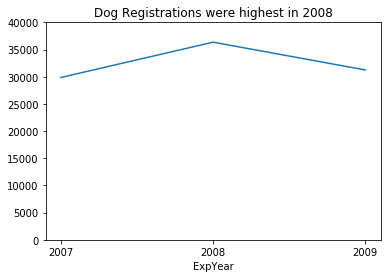

In [6]:
(
dogs
    .groupby('ExpYear')
    ['Breed']
    .count()
    .plot
    .line(
        xticks=dogs['ExpYear'].unique(), # this tells it to only use the three populated years as x-tick labels
        ylim=(0,40000), # this manually sets the scale of the y axis
        title='Dog Registrations were highest in 2008', # chart title!
    )
)

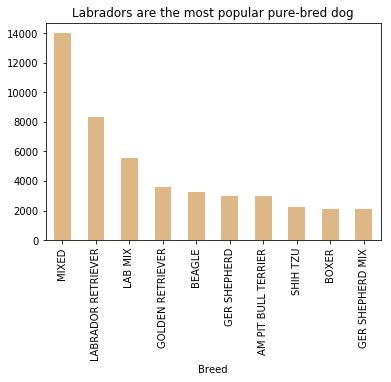

In [7]:
(
dogs.groupby('Breed')
    ['ExpYear']
    .count()
    .sort_values(ascending=False)[:10]
    .plot
    .bar(color='burlywood', # any legal html colour name works here!
         title='Labradors are the most popular pure-bred dog')
)

A particularly interesting method within `plot` is `hist`. That'll automatically calculate a histogram for you!

In [8]:
dogs['ValidDate_dt'] = pd.to_datetime(dogs['ValidDate'])

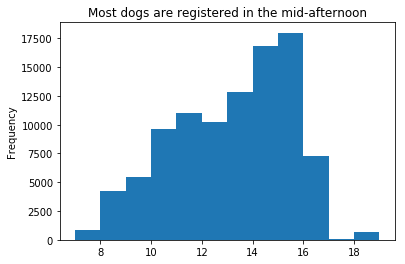

In [9]:
(
dogs['ValidDate_dt']
    .dt.hour
    .plot
    .hist(
        bins=12, # This is an argument that only exists in the hist function!
        title='Most dogs are registered in the mid-afternoon')
)

Don't forget that any `DataFrame` will have a `plot` method as well! That's a good way of plotting multiple series on one chart. Each numeric column in your `DataFrame` becomes a series in the chart.

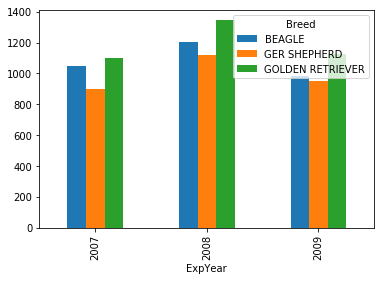

In [56]:
(
dogs
    .loc[dogs['Breed'].
         isin(['GOLDEN RETRIEVER', 'BEAGLE', 'GER SHEPHERD'])]
    .groupby(['ExpYear', 'Breed'])
    ['Breed']
    .count()
    .unstack()
    .plot
    .bar()
)

### Problems

* Make a bar chart showing counts of the top 10 dog colours
* Make a line chart comparing registrations of dogs called "Buddy" to dogs called "Bella" over time.

## More Complex Charts

Sometimes you want to do something that's not quite supported by the built in charting within Pandas. That's when you need to fall back on the underlying `matplotlib` library. Fortunately, they work together almost seamlessly. Unfortunately, the way they work together is kind of mysterious, and what is sometimes called "un-Pythonic" - it works, but it doesn't quite work the same as most other libraries. Let me demonstrate.

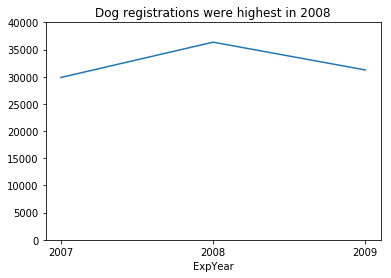

In [11]:
(
dogs
    .groupby('ExpYear')
    ['Breed']
    .count()
    .plot
    .line()
)
plt.xticks([2007, 2008, 2009])
plt.ylim((0, 40000))
plt.title('Dog registrations were highest in 2008')
plt.show()

What's going on here? We're talking to the `matplotlib.pyplot` library we imported earlier (and renamed `plt`). But when we pass it instructions, it somehow knows to apply those instructions to the chart that we created from Pandas! Wild!

What's happening is that in the background, there's a kind of "hidden" object that is passed to `matplotlib` when the chart is created - a reference to the chart. From then on, until you create a new chart entirely, any calls to `plt` will implicitly know to apply to this chart.

In the code above, we just replicated all the behaviour that we were already using by passing arguments to the Pandas `plot` function. But `matplotlib.pyplot` gives us access to a bunch more stuff that can be very useful.

### Plotting more than one thing

Sometimes you want to plot two different things on the same chart. This is actually really simple. So long as all of the things you're plotting share the same x axis, you can just keep calling the `plot` method, and it'll just keep overlaying them. You might have to manually add your own legend though. Pass a list of series names in the same order as you plotted the charts.

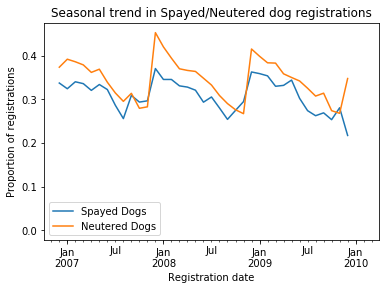

In [191]:
(
dogs
    .set_index(dogs['ValidDate_dt'])
    ['LicenseType']
    .str
    .contains('Neutered')
    .resample('1M')
    .mean()
    .plot
    .line()
)
(
dogs
    .set_index(dogs['ValidDate_dt'])
    ['LicenseType']
    .str
    .contains('Spayed')
    .resample('1M')
    .mean()
    .plot
    .line()
)

plt.title('Seasonal trend in Spayed/Neutered dog registrations')
plt.legend(['Spayed Dogs', 'Neutered Dogs'])
plt.ylabel('Proportion of registrations')
plt.xlabel('Registration date')
plt.show()

That's fine if you're plotting things on the same y-axis. If you want a different y-axis for one or more series, that gets quite fiddly. You've gotta use the `secondary_y` argument of the `plot` method, which is quite straightforward. The tricky bit is getting the legend and the axis labels to work correctly. You've got to construct a weird tuple from the `AxesSubplot` objects that're returned by the `plot` method, and use that to build your legend. It's annoying!

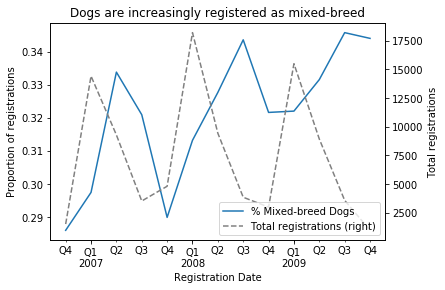

In [196]:
ax1 = (
dogs
    .set_index(dogs['ValidDate_dt'])
    ['Breed']
    .str
    .contains('MIX')
    .resample('3M')
    .mean()
    [:-1]
    .plot
    .line()
)

plt.ylabel('Proportion of registrations') # you gotta set this before you plot the next series

ax2 = (
dogs
    .set_index(dogs['ValidDate_dt'])
    .resample('3M')
    ['DogName']
    .count()
    [:-1]
    .plot
    .line(secondary_y=True,
         linestyle='--',
         color='grey')
)

plt.ylabel('Total registrations')

# building the legend (it's annoying!)
lines = ax1.get_lines() + ax2.get_lines()
plt.legend(lines,
           ['% Mixed-breed Dogs', 'Total registrations (right)'],
           loc='lower right')

plt.title('Dogs are increasingly registered as mixed-breed')
ax1.set_xlabel('Registration Date') # note that plt.xlabel doesn't work here for some reason
plt.show()

### Annotations

You can annotate your charts with arbitrary text using the `annotate` method in the `pyplot` library. It takes a couple of key arguments:
* label:  The value we want to show in the data label
* xy: The position of the label. For bar charts, the x positions are 0, 1, 2 etc.

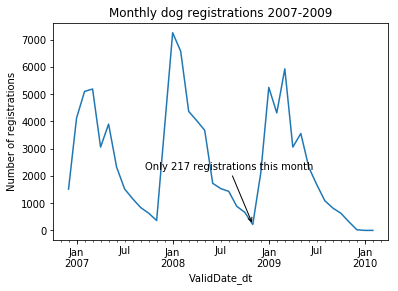

In [89]:
monthly = (
    dogs
        .set_index(dogs['ValidDate_dt'])
        .resample('1M')
        ['Breed']
        .count()
          )
monthly.plot()

x, y = monthly.index[23], monthly.values[23]  # we pull the coordinates for the annotation from the data itself

plt.annotate(f'Only {y} registrations this month',
            xy=(x, y),
            xytext=(monthly.index[20], y+2000),  # this is the location for the text
            ha='center',  # this aligns the text on the center of the position
            arrowprops={'arrowstyle': '->'}
            )

plt.title('Monthly dog registrations 2007-2009')
plt.ylabel('Number of registrations') # You can label your axis here!
plt.show()

### Data Labels

Honestly I can't believe that this is as complex as it is. You have to iterate through a list of the data values, and manually add a label at the specified point in the chart. It's infuriating.

We use the `annotate` method again, but this time inside a little loop.

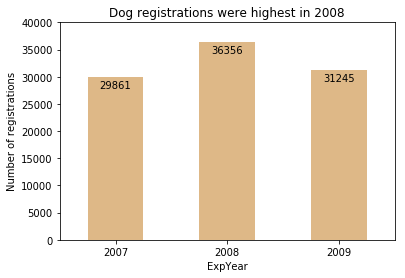

In [90]:
years = (
    dogs
    .groupby('ExpYear')
    ['Breed']
    .count()
)
(
years
    .plot
    .bar(color='burlywood',
        rot=0) # rotates the x-tick labels
)

for x, registrations in enumerate(years): # iterate through the values for each year (as well as an index - 0, 1, 2)
    plt.annotate(registrations,
                 xy=(x, registrations-2000),
                 ha='center'
                )

plt.ylim((0, 40000))
plt.title('Dog registrations were highest in 2008')
plt.ylabel('Number of registrations')
plt.show()

### Confidence Ranges

There's lots of ways to represent confidence ranges, but a thing I often want to do is show a shaded area behind a solid line chart. There's a very useful method that does exactly this, called `fill_between`. It expects:
* A series of x-values. These should be the same as for your main plot.
* Two series of y-values. It'll fill between them.
* An "alpha" value, which sets the transparency.

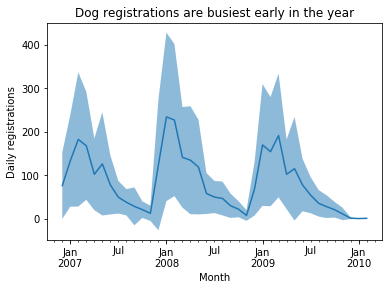

In [96]:
data = (
    dogs
        .set_index(dogs['ValidDate_dt'])
        .resample('1D')
        ['DogName']
        .count()
        .resample('1M')
)
(
data
    .mean()
    .plot
    .line()
)
plt.fill_between(
    x=data.mean().index,
    y1=data.mean() - data.std(),
    y2=data.mean() + data.std(),
    alpha=0.5
)
plt.title('Dog registrations are busiest early in the year')
plt.ylabel('Daily registrations')
plt.xlabel('Month')
plt.show()

### Problems

* Chart the monthly proportion of dogs called "Bella" and the proportion of dogs called "Buddy"
* Annotate the month with the highest proportion for each name.

## Prettier Charts

There's a whole lot of other libraries that can help you make prettier charts in Python, more easily than with plain old `matplotlib`. There are a lot of arguments in favour of each of them. For myself, I think `seaborn` is maybe the best tradeoff between ease of use, prettiness, and compatibility with `matplotlib` functionality. You may reach a different conclusion. For prettier charts, I suggest looking into one of those.